In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Font tiếng Việt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False


2025-12-26 16:17:27.792103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-26 16:17:27.792707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-26 16:17:27.874185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-26 16:17:28.083194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-26 16:17:29.340035: W tensorflow/compiler/tf2

In [ ]:
# 1. CONFIG & DATA GENERATOR

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40

DATA_DIR = "../data"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")

# Train generator (augmentation mạnh nhưng an toàn cho vết bệnh)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
    validation_split=0.2
)

# Validation generator (chỉ rescale)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_IMG_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED,
    subset="training"
)

valid_generator = valid_datagen.flow_from_directory(
    TRAIN_IMG_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=SEED,
    subset="validation"
)

NUM_CLASSES = train_generator.num_classes
print("Số lớp bệnh:", NUM_CLASSES)


Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Số lớp bệnh: 10


In [ ]:
# 2. BUILD PRO CNN MODEL

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # Block 5 (deep features)
    layers.Conv2D(512, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),

    # Global pooling thay cho Flatten
    layers.GlobalAveragePooling2D(),

    # Classifier
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()


2025-12-26 16:17:33.425672: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-26 16:17:34.280199: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-26 16:17:34.280277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-26 16:17:34.283871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-26 16:17:34.283984: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      2

In [ ]:
# 3. COMPILE MODEL

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# 4. CALLBACKS

MODEL_PATH = "../models/cnn_person1_best.keras"

checkpoint_cb = callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

earlystop_cb = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,      # Giảm LR 5 lần
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
# 5. TRAINING

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)


Epoch 1/40


2025-12-26 16:17:38.679609: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-12-26 16:17:39.193281: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-12-26 16:17:40.738171: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-12-26 16:17:43.730096: I external/local_xla/xla/service/service.cc:168] XLA service 0x713e891ef2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-26 16:17:43.730156: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro T2000, Compute Capability 7.5
2025-12-26 16:17:43.802244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766740664.081842   19777 device_compiler.h:186] Comp

261/261 [==============================] - ETA: 0s - loss: 2.0032 - accuracy: 0.2926
Epoch 1: val_accuracy improved from -inf to 0.17670, saving model to ../models/cnn_person1_best.keras
261/261 [==============================] - 205s 737ms/step - loss: 2.0032 - accuracy: 0.2926 - val_loss: 2.8751 - val_accuracy: 0.1767 - lr: 0.0010
Epoch 2/40
261/261 [==============================] - ETA: 0s - loss: 1.7221 - accuracy: 0.3922
Epoch 2: val_accuracy improved from 0.17670 to 0.38806, saving model to ../models/cnn_person1_best.keras
261/261 [==============================] - 187s 715ms/step - loss: 1.7221 - accuracy: 0.3922 - val_loss: 1.8493 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 3/40
261/261 [==============================] - ETA: 0s - loss: 1.5156 - accuracy: 0.4643
Epoch 3: val_accuracy improved from 0.38806 to 0.51613, saving model to ../models/cnn_person1_best.keras
261/261 [==============================] - 182s 698ms/step - loss: 1.5156 - accuracy: 0.4643 - val_loss: 1.3671 - v

2025-12-26 16:33:05.867750: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268864 bytes after encountering the first element of size 19268864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 5: val_accuracy did not improve from 0.51613
261/261 [==============================] - 190s 729ms/step - loss: 1.2907 - accuracy: 0.5503 - val_loss: 2.6800 - val_accuracy: 0.3659 - lr: 0.0010
Epoch 6/40
261/261 [==============================] - ETA: 0s - loss: 1.2277 - accuracy: 0.5721
Epoch 6: val_accuracy did not improve from 0.51613

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
261/261 [==============================] - 186s 714ms/step - loss: 1.2277 - accuracy: 0.5721 - val_loss: 2.2472 - val_accuracy: 0.3645 - lr: 0.0010
Epoch 7/40
261/261 [==============================] - ETA: 0s - loss: 1.0449 - accuracy: 0.6341
Epoch 7: val_accuracy improved from 0.51613 to 0.62157, saving model to ../models/cnn_person1_best.keras
261/261 [==============================] - 192s 734ms/step - loss: 1.0449 - accuracy: 0.6341 - val_loss: 1.0910 - val_accuracy: 0.6216 - lr: 2.0000e-04
Epoch 8/40
261/261 [==============================] - ETA: 0s - loss: 0.98

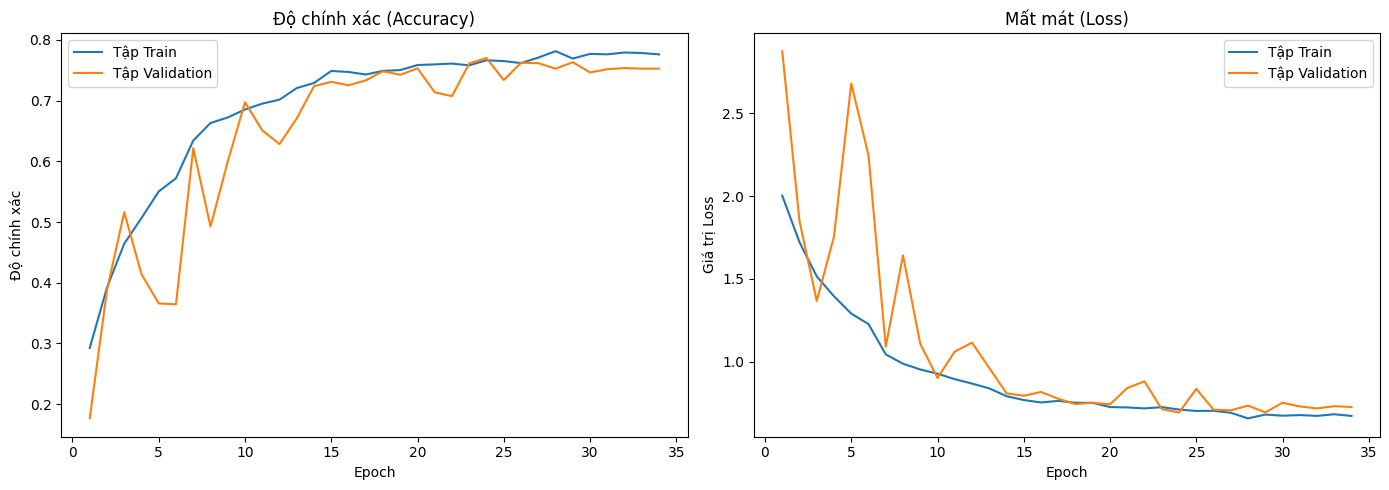

In [ ]:
# 6. TRAINING HISTORY PLOT (VI)
history_dict = history.history
epochs_range = range(1, len(history_dict["accuracy"]) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict["accuracy"], label="Tập Train")
plt.plot(epochs_range, history_dict["val_accuracy"], label="Tập Validation")
plt.title("Độ chính xác (Accuracy)")
plt.xlabel("Epoch")
plt.ylabel("Độ chính xác")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict["loss"], label="Tập Train")
plt.plot(epochs_range, history_dict["val_loss"], label="Tập Validation")
plt.title("Mất mát (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Giá trị Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 6. ĐÁNH GIÁ TRÊN TẬP VALID

val_loss, val_acc = model.evaluate(valid_generator, verbose=1)
print(f"Độ chính xác (validation): {val_acc:.4f}")
print(f"Mất mát (validation): {val_loss:.4f}")
